# Malaria Detection

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.
* In 2017, there were an estimated 219 million cases of malaria in 90 countries.
* Malaria deaths reached 435 000 in 2017.
* The WHO African Region carries a disproportionately high share of the global malaria burden. In 2017, the region was home to 92% of malaria cases and 93% of malaria deaths.

Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.


***Diagnosis of malaria can be difficult***:

* Where malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.
* Malaria is an acute febrile illness. In a non-immune individual, symptoms usually appear 10–15 days after the infective mosquito bite. The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria. If not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.

***Microscopic Diagnosis***

Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained  to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.

![malaria](https://cdn1.sph.harvard.edu/wp-content/uploads/2015/03/Malaria-cells_CDC.jpg)

references :
* [1] https://www.who.int/news-room/fact-sheets/detail/malaria 
* [2] https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html 


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os
print(os.listdir("cell_images"))

['Parasitized', 'Uninfected']


## Dataset

In [5]:
img_dir='C:\\Users\\Atulya\\Documents\\GitHub\\ML-healthcare-diagnosis\\Malaria using Cell Images\\cell_images'

In [6]:
path=Path(img_dir)
path

WindowsPath('C:/Users/Atulya/Documents/GitHub/ML-healthcare-diagnosis/Malaria using Cell Images/cell_images')

In [7]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [8]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Parasitized', 'Uninfected']


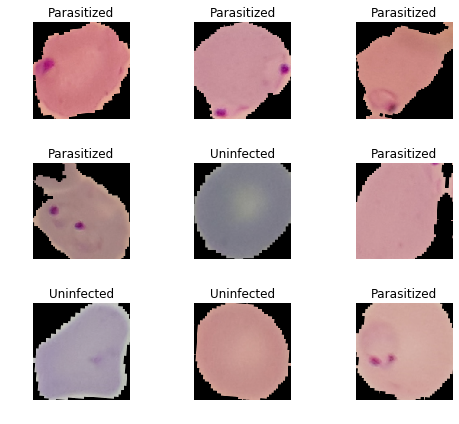

In [9]:
data.show_batch(rows=3, figsize=(7,6))

## Model ResNet34

In [10]:
learn = create_cnn(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Atulya/.torch\models\resnet34-333f7ec4.pth
100%|██████████████████████████████████████████████████████████████████| 87306240/87306240 [02:28<00:00, 586968.89it/s]


In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy


In [ ]:
learn.fit_one_cycle(6,1e-2)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,5e-5 ))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

## Confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Inference

In [ ]:
pred_data= ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [ ]:
predictor=create_cnn(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/").load('stage-2')

In [ ]:
pred_data.single_from_classes(path, pred_data.classes)

In [ ]:
x,y = data.valid_ds[3]
x.show()
data.valid_ds.y[3]

In [ ]:
pred_class,pred_idx,outputs = predictor.predict(x)
pred_class

## Heatmap
The heatmap will help us identify were our model it's looking and it's really useful for decision making

In [ ]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.5, extent=size,
              interpolation='bilinear', cmap='magma')
    

In [ ]:
heatMap(x,y,pred_data,learn)